In [1]:
from utilities import *
from core.initial import Insertions
from docplex.cp.model import *
from IPython.display import display
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline


In [2]:
datafile = "C:/Users/aznavouridis.k/My Drive/MSc MST-AUEB/_Thesis_/Main Thesis/Model Data.xlsx"

d = DataProvider(filepath=datafile, route='910')

model = CSPModel(d)
model.build_model()

model.data.head()

,initial_depot,final_depot,relief_point,time,trip_duration,start_time,end_time
trip,,,,,,,
0,Fix Station,Fix Station,NaN,05:00,40,300,340
1,Fix Station,Fix Station,NaN,05:20,40,320,360
2,Fix Station,Fix Station,NaN,05:55,40,355,395
3,Fix Station,Fix Station,NaN,06:20,44,380,424
4,Fix Station,Fix Station,NaN,06:40,44,400,444


In [ ]:
initial = Insertions(model)
initial.solve()

In [3]:
model.start_times

array([ 300,  320,  355,  380,  400,  420,  435,  450,  465,  480,  495,
        515,  530,  545,  565,  580,  595,  610,  625,  645,  660,  675,
        695,  710,  725,  745,  760,  775,  795,  810,  825,  845,  860,
        875,  895,  910,  925,  945,  960,  975,  995, 1010, 1025, 1045,
       1060, 1080, 1105, 1130, 1150, 1170, 1190, 1215, 1240, 1270, 1305,
       1345, 1385, 1420], dtype=int64)

In [4]:
model.end_times

array([ 340,  360,  395,  424,  444,  468,  483,  498,  513,  532,  547,
        567,  582,  597,  617,  632,  647,  654,  669,  689,  704,  719,
        739,  754,  769,  789,  804,  819,  839,  854,  869,  893,  908,
        923,  943,  958,  973,  993, 1012, 1027, 1047, 1062, 1077, 1097,
       1112, 1124, 1149, 1174, 1194, 1214, 1234, 1259, 1284, 1310, 1345,
       1385, 1425, 1460], dtype=int64)

In [8]:
model.end_times[:-1] - model.start_times[1:]

array([20,  5, 15, 24, 24, 33, 33, 33, 33, 37, 32, 37, 37, 32, 37, 37, 37,
       29, 24, 29, 29, 24, 29, 29, 24, 29, 29, 24, 29, 29, 24, 33, 33, 28,
       33, 33, 28, 33, 37, 32, 37, 37, 32, 37, 32, 19, 19, 24, 24, 24, 19,
       19, 14,  5,  0,  0,  5], dtype=int64)

In [ ]:
trips = [interval_var(start=(trip.start_time, trip.start_time),
                      end=(trip.end_time, trip.end_time),
                      size=trip.duration,
                      name=f'Trip_{idx}') for idx, trip in enumerate(model.trips)]


In [ ]:
ntrips = len(model.trips)
nduties = len(model.trips)

sub = CpoModel(name="Pricing_Subproblem")

# Variables

min_start = model.data[start_time].min()
max_start = model.data[start_time].max()
min_end = model.data[end_time].min()
max_end = model.data[end_time].max()

duties = [interval_var(start=(min_start, max_start),
                       end=(min_end, max_end),
                       size=model.constraints.shift_span,
                       name=f"Duty_{i}",
                       optional=True)
          for i in range(nduties)]

trip2trip = integer_var_list(size=ntrips,
                             min=0,
                             max=ntrips + 1,
                             name='Trip2Trip')

trip2duty = integer_var_list(size=ntrips,
                             min=0,
                             max=nduties,
                             name='Trip2Duty')

start_times = [[integer_var(min=0,
                            max=model.constraints.shift_span,
                            name=f"StartTime-{i}-{j}")
               for j in range(nduties)] for i in range(ntrips)]

cdt = integer_var_list(size=nduties,
                       min=0,
                       max=model.constraints.continuous_driving,
                       name="CDT")

tdt = integer_var_list(size=nduties,
                       min=0,
                       max=model.constraints.total_driving,
                       name="TDT")

# Constraints

for i in range(ntrips):
    for j in range(ntrips):
        sub.add(sub.if_then(
            trip2trip[i] == j, model.end_times[i] <= model.start_times[j]))

for i in range(ntrips):
    for j in range(ntrips):
        sub.add(sub.if_then(
            trip2trip[i] == j, model.end_locs[i] <= model.start_locs[j]))

for i in range(ntrips):
    sub.add(trip2trip[i] != i)

for i in range(ntrips):
    for j in range(ntrips):
        sub.add(sub.if_then(trip2trip[i] == j, trip2duty[i] == trip2duty[j]))


In [ ]:
def report_solution(cpsol: CpoSolveResult):
    trips_per_duty = {}
    for i in range(ntrips):
        _out = f"{i:>2} -> {cpsol[trip2trip[i]]} | Duty: {cpsol[trip2duty[i]]}"
        # print(_out)

        duty_id = cpsol[trip2duty[i]]

        if duty_id in trips_per_duty:
            trips_per_duty[duty_id].append(i)
        else:
            trips_per_duty[duty_id] = []
            trips_per_duty[duty_id].append(i)

    print(f'\n\nTotal Duties: {len(trips_per_duty.keys())}')

    for duty_id, duty_trips in trips_per_duty.items():
        df_trips = model.data.loc[duty_trips]

        span = df_trips[end_time].max() - df_trips[start_time].min()

        print(
            f'\n\n>>> Duty {duty_id} - Trips: {len(duty_trips)} - Drive Time: {df_trips[trip_duration].sum()} - Shift Span: {span}\n')
        display(df_trips)

In [3]:
model.trips = model.trips[:20]
NTRIPS = len(model.trips)
NDUTIES = 6

In [4]:
NTRIPS = len(model.trips)
NDUTIES = 10

In [5]:
sub = CpoModel(name="Pricing_Subproblem")

min_start = model.data[start_time].min()
max_start = model.data[start_time].max()
min_end = model.data[end_time].min()
max_end = model.data[end_time].max()

# trips = [interval_var(start=(trip.start_time, trip.start_time),
#                       end=(trip.end_time, trip.end_time),
#                       size=trip.duration,
#                       name=f'Trip_{idx}') for idx, trip in enumerate(model.trips)]


duties = [interval_var(start=(min_start, max_start),
                       end=(min_end, max_end),
                       size=(0, model.constraints.shift_span),
                       name=f"Duty_{i}",
                       optional=True)
          for i in range(NDUTIES)]

breaks = [interval_var(size=model.constraints.break_time,
                       name=f"BreakTime_{i}",
                       optional=True)
          for i in range(NDUTIES)]

trip2duty = {}
for t, trip in enumerate(model.trips):
    for d in range(NDUTIES):
        trip2duty[(t, d)] = sub.interval_var(start=(trip.start_time, trip.start_time),
                                             end=(trip.end_time, trip.end_time),
                                             size=trip.duration,
                                             name=f"Trip_{t:02} | Duty_{d:02}",
                                             optional=True)

In [5]:
for d in range(NDUTIES):
    sub.add(sub.span(duties[d], [trip2duty[(t, d)] for t in range(NTRIPS)]))

for d in range(NDUTIES):
    sub.add(sub.no_overlap([trip2duty[(t, d)] for t in range(NTRIPS)]))

for t in range(NTRIPS):
    sub.add(sub.sum([sub.presence_of(trip2duty[(t, d)]) for d in range(NDUTIES)]) == 1)

In [ ]:
cdt = {}
tdt = {}

for d in range(nduties):
    cdt[d] = sub.step_at(0, 0)
    tdt[d] = sub.step_at(0, 0)
    for t in range(ntrips):
        cdt[d] += sub.pulse(trip2duty[(t,d)], model.durations[t])
        tdt[d] += sub.pulse(trip2duty[(t,d)], model.durations[t])

    sub.add(cdt[d] <= model.constraints.continuous_driving)
    sub.add(tdt[d] <= model.constraints.total_driving)
  

In [6]:
obj = sub.sum([sub.presence_of(duty) for duty in duties])
sub.add(sub.minimize(obj))

In [7]:
cpsol = sub.solve()

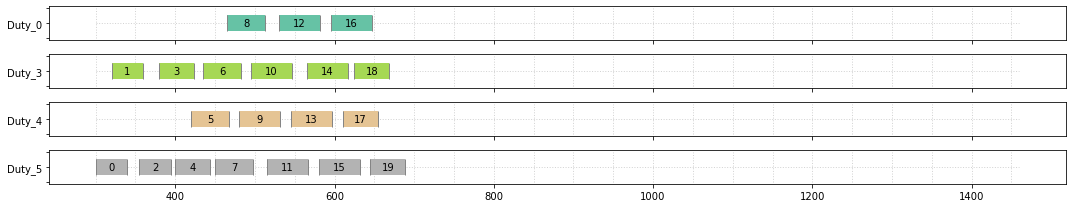

In [17]:
rcParams['figure.figsize'] = 15, 3
visu.timeline('Driver Scheduling', origin=min_start, horizon=max_end)
for d in range(NDUTIES):
    if cpsol[duties[d]]:
        visu.panel()
        _d = cpsol.get_var_solution(duties[d])
        # visu.interval(_d, 'lightblue', duties[d].get_name())
        visu.sequence(name=duties[d].get_name(),
                      intervals=[(cpsol.get_var_solution(trip2duty[(t, d)]), d, str(t)) for t in range(NTRIPS) if cpsol[trip2duty[(t, d)]]])
visu.show()


In [9]:
trip2duty[0, 0].size

(40, 40)

In [10]:
cdt = step_at(0, 0)

In [ ]:
cpsol.get_infos()

In [ ]:
cpsol.get_objective_bounds()

In [ ]:
cpsol.get_objective_gaps()

In [ ]:
cpsol.get_parameters()

In [ ]:
cpsol.get_search_status()

In [ ]:
cpsol.get_solution()

In [ ]:
cpsol.get_solve_status()

In [ ]:
cpsol.get_value(trip2duty[8, 6])

In [ ]:
cpsol.print_solution()

In [ ]:
cpsol.process_infos

In [ ]:
cpsol.write("C:/Users/aznavouridis.k/Desktop/test.txt")